# DL Project 24/25

## Download and unzip test dataset

In [1]:
!gdown 1G7u9RBG_2_vY889Fsb2hMGz_AB8jzJMR
!mkdir dataset
!tar -xvf  'imagenet-a.tar' -C 'dataset'

zsh:1: command not found: gdown


mkdir: impossibile creare la directory "dataset": File già esistente
tar: imagenet-a.tar: funzione "open" non riuscita: File o directory non esistente
tar: Error is not recoverable: exiting now


## Import necessary libraries

In [15]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from pkg_resources import packaging
from torchvision.io import read_image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from .simple_tokenizer import SimpleTokenizer as _Tokenizer
from typing import Any, Union, List,Tuple

## Parameters

In [ ]:
DEVICE= "gpu:0"

## Dataset Loader

In [2]:
class DatasetImageNetA(Dataset):
    def __init__(self, dataset_path, transform=None, target_transform=None):
        self.dataset_path = dataset_path
        self.transform = transform
        self.target_transform = target_transform

        # Read the mapping file
        with open(os.path.join(dataset_path ,"README.txt"), "r") as f:
            lines = f.readlines()[12:] #skips first 12 lines

        # Create the mapping dictionary
        self.mapping = {}
        for line in lines:
            split_line = line.split()
            if len(split_line) > 1:
                numeric_id = split_line[0][1:]
                name = " ".join(split_line[1:]).strip()
                self.mapping[int(numeric_id)] = name.lower()

        # Create the labels list
        labels = []
        for cl in self.mapping.keys():
            for file_name in os.listdir(os.path.join(dataset_path, f"n{str(cl).zfill(8)}")):
                labels.append((cl, file_name))
        self.labels=labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.dataset_path, f"n{str(self.labels[idx][0]).zfill(8)}", self.labels[idx][1])
        image = read_image(img_path)
        label = self.labels[idx][0]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [3]:
val_data = DatasetImageNetA(os.path.join("dataset", "imagenet-a"))
val_dataloader = DataLoader(val_data, batch_size=1, shuffle=True)

Feature batch shape: torch.Size([1, 3, 500, 375])
Labels batch shape: torch.Size([1])


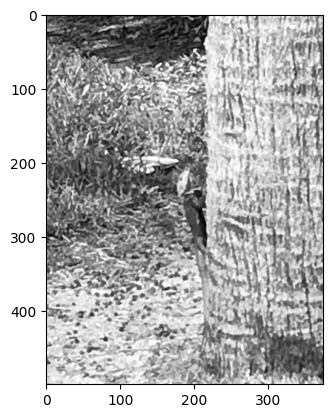

Label: 1687978
agama


In [4]:
# Quick test to check if dataset loader works correctly
train_features, train_labels = next(iter(val_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0][0].numpy()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")
print(val_data.mapping[int(label)])

## Load the model

In [5]:
from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

## Create the prompts

In [6]:
prompts = []
for key in val_data.mapping:
    prompts.append("a photo of a " + val_data.mapping[key])
print(prompts)

['a photo of a stingray', 'a photo of a goldfinch', 'a photo of a junco', 'a photo of a american robin', 'a photo of a jay', 'a photo of a bald eagle', 'a photo of a vulture', 'a photo of a newt', 'a photo of a american bullfrog', 'a photo of a box turtle', 'a photo of a green iguana', 'a photo of a agama', 'a photo of a chameleon', 'a photo of a american alligator', 'a photo of a garter snake', 'a photo of a harvestman', 'a photo of a scorpion', 'a photo of a tarantula', 'a photo of a centipede', 'a photo of a sulphur-crested cockatoo', 'a photo of a lorikeet', 'a photo of a hummingbird', 'a photo of a toucan', 'a photo of a duck', 'a photo of a goose', 'a photo of a koala', 'a photo of a jellyfish', 'a photo of a sea anemone', 'a photo of a flatworm', 'a photo of a snail', 'a photo of a crayfish', 'a photo of a hermit crab', 'a photo of a flamingo', 'a photo of a great egret', 'a photo of a oystercatcher', 'a photo of a pelican', 'a photo of a sea lion', 'a photo of a chihuahua', 'a 

## Predict label

In [7]:
img = train_features[0]

inputs = processor(text=prompts, images=img, return_tensors="pt", padding=True)
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities

predicted_label_index = torch.argmax(probs, dim=1)

# Get the predicted label based on the index
predicted_label = prompts[predicted_label_index]

# Print the predicted label and its probability
predicted_probability = probs[0][predicted_label_index].item()

print(f"Predicted label: {predicted_label}")
print(f"Probability: {predicted_probability:.4f}")

Predicted label: a photo of a fox squirrel
Probability: 0.8215


In [11]:
print(model)

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

In [9]:
print(model.vision_model)

CLIPVisionTransformer(
  (embeddings): CLIPVisionEmbeddings(
    (patch_embedding): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (position_embedding): Embedding(50, 768)
  )
  (pre_layrnorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (encoder): CLIPEncoder(
    (layers): ModuleList(
      (0-11): 12 x CLIPEncoderLayer(
        (self_attn): CLIPSdpaAttention(
          (k_proj): Linear(in_features=768, out_features=768, bias=True)
          (v_proj): Linear(in_features=768, out_features=768, bias=True)
          (q_proj): Linear(in_features=768, out_features=768, bias=True)
          (out_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): CLIPMLP(
          (activation_fn): QuickGELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
    

In [10]:
print(model.text_model)

CLIPTextTransformer(
  (embeddings): CLIPTextEmbeddings(
    (token_embedding): Embedding(49408, 512)
    (position_embedding): Embedding(77, 512)
  )
  (encoder): CLIPEncoder(
    (layers): ModuleList(
      (0-11): 12 x CLIPEncoderLayer(
        (self_attn): CLIPSdpaAttention(
          (k_proj): Linear(in_features=512, out_features=512, bias=True)
          (v_proj): Linear(in_features=512, out_features=512, bias=True)
          (q_proj): Linear(in_features=512, out_features=512, bias=True)
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
        )
        (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (mlp): CLIPMLP(
          (activation_fn): QuickGELUActivation()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
        )
        (layer_norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      )
    )
  )
  (final_layer_norm

In [12]:
model.dtype

torch.float32

In [27]:
#changed some symble to adapt to our version of CLIP
class TextEncoder(nn.Module):
    def __init__(self,clip_model):
        super().__init__()
        self.transformer = clip_model.text_model
        self.positional_embedding = clip_model.text_model.embeddings.position_embedding
        self.ln_final = clip_model.text_model.final_layer_norm
        self.text_projection = clip_model.text_projection
        self.dtype = clip_model.dtype
    
    def forward(self, prompts, tokenized_prompts):
        x = prompts + self.positional_embedding.type(self.dtype)
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.ln_final(x).type(self.dtype)

        # x.shape = [batch_size, n_ctx, transformer.width]
        # take features from the eot embedding (eot_token is the highest number in each sequence)
        x = x[torch.arange(x.shape[0]), tokenized_prompts.argmax(dim=-1)] @ self.text_projection

        return x

In [28]:
print(TextEncoder(model))

TextEncoder(
  (transformer): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps

In [36]:
model.vision_model.to("cuda:0")

CLIPVisionTransformer(
  (embeddings): CLIPVisionEmbeddings(
    (patch_embedding): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (position_embedding): Embedding(50, 768)
  )
  (pre_layrnorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (encoder): CLIPEncoder(
    (layers): ModuleList(
      (0-11): 12 x CLIPEncoderLayer(
        (self_attn): CLIPSdpaAttention(
          (k_proj): Linear(in_features=768, out_features=768, bias=True)
          (v_proj): Linear(in_features=768, out_features=768, bias=True)
          (q_proj): Linear(in_features=768, out_features=768, bias=True)
          (out_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): CLIPMLP(
          (activation_fn): QuickGELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
    

In [ ]:
class PromptLearner(nn.Module):
    def __init__(self, clip_model, classnames, clip_processor, batch_size=None, n_ctx=16, ctx_init=None, ctx_position='end', learned_cls=False):
        super().__init__()
        n_cls = len(classnames)
        self.learned_cls = learned_cls
        dtype = clip_model.dtype
        self.dtype = dtype
        self.device = DEVICE
        #TODO ctx_dim = clip_model.ln_final.weight.shape[0] Adapt it to our CLIP
        ctx_dim = 768
        self.ctx_dim = ctx_dim
        self.batch_size = batch_size
        self.cl

        # self.ctx, prompt_prefix = self.reset_prompt(ctx_dim, ctx_init, clip_model)

        if ctx_init:
            # use given words to initialize context vectors
            print(
                "Initializing the contect with given words: [{}]".format(ctx_init))
            ctx_init = ctx_init.replace("_", " ")
            if '[CLS]' in ctx_init:
                ctx_list = ctx_init.split(" ")
                split_idx = ctx_list.index("[CLS]")
                ctx_init = ctx_init.replace("[CLS] ", "")
                ctx_position = "middle"
            else:
                split_idx = None
            self.split_idx = split_idx
            n_ctx = len(ctx_init.split(" "))
            prompt = clip_processor.tokenizer.tokenize(ctx_init).to(self.device)
            with torch.no_grad():
                embedding = clip_model.text_model.position_embedding(
                    prompt).type(dtype)
            ctx_vectors = embedding[0, 1: 1 + n_ctx, :]
            prompt_prefix = ctx_init
        else:
            print("Random initialization: initializing a generic context")
            ctx_vectors = torch.empty(n_ctx, ctx_dim, dtype=dtype)
            nn.init.normal_(ctx_vectors, std=0.02)
            prompt_prefix = " ".join(["X"] * n_ctx)

        self.prompt_prefix = prompt_prefix

        print(f'Initial context: "{prompt_prefix}"')
        print(f"Number of context words (tokens): {n_ctx}")

        # batch-wise prompt tuning for test-time adaptation
        if self.batch_size is not None:
            ctx_vectors = ctx_vectors.repeat(batch_size, 1, 1)  # (N, L, D)
        self.ctx_init_state = ctx_vectors.detach().clone()
        self.ctx = nn.Parameter(ctx_vectors)  # to be optimized

        if not self.learned_cls:
            classnames = [name.replace("_", " ") for name in classnames]
            name_lens = [len(_tokenizer.encode(name)) for name in classnames]
            prompts = [prompt_prefix + " " + name + "." for name in classnames]
        else:
            print("Random initialization: initializing a learnable class token")
            # assume each learnable cls_token is only 1 word
            cls_vectors = torch.empty(n_cls, 1, ctx_dim, dtype=dtype)
            nn.init.normal_(cls_vectors, std=0.02)
            cls_token = "X"
            name_lens = [1 for _ in classnames]
            prompts = [prompt_prefix + " " +
                       cls_token + "." for _ in classnames]

            self.cls_init_state = cls_vectors.detach().clone()
            self.cls = nn.Parameter(cls_vectors)  # to be optimized

        tokenized_prompts = torch.cat([tokenize(p)
                                      for p in prompts]).to(self.device)
        with torch.no_grad():
            embedding = clip_model.token_embedding(
                tokenized_prompts).type(dtype)

        # These token vectors will be saved when in save_model(),
        # but they should be ignored in load_model() as we want to use
        # those computed using the current class names
        self.register_buffer("token_prefix", embedding[:, :1, :])  # SOS
        if self.learned_cls:
            self.register_buffer(
                "token_suffix", embedding[:, 1 + n_ctx + 1:, :])  # ..., EOS
        else:
            self.register_buffer(
                "token_suffix", embedding[:, 1 + n_ctx:, :])  # CLS, EOS

        self.ctx_init = ctx_init
        self.tokenized_prompts = tokenized_prompts  # torch.Tensor
        self.name_lens = name_lens
        self.class_token_position = ctx_position
        self.n_cls = n_cls
        self.n_ctx = n_ctx
        self.classnames = classnames
        self.clip_model = clip_model

    def forward(self, init=None):
        # the init will be used when computing CLIP directional loss
        if init is not None:
            ctx = init
        else:
            ctx = self.ctx
        if ctx.dim() == 2:
            ctx = ctx.unsqueeze(0).expand(self.n_cls, -1, -1)
        elif not ctx.size()[0] == self.n_cls:
            ctx = ctx.unsqueeze(1).expand(-1, self.n_cls, -1, -1)

        prefix = self.token_prefix
        suffix = self.token_suffix
        if self.batch_size is not None:
            # This way only works for single-gpu setting (could pass batch size as an argument for forward())
            prefix = prefix.repeat(self.batch_size, 1, 1, 1)
            suffix = suffix.repeat(self.batch_size, 1, 1, 1)

        if self.learned_cls:
            assert self.class_token_position == "end"
        if self.class_token_position == "end":
            if self.learned_cls:
                cls = self.cls
                prompts = torch.cat(
                    [
                        prefix,  # (n_cls, 1, dim)
                        ctx,     # (n_cls, n_ctx, dim)
                        cls,     # (n_cls, 1, dim)
                        suffix,  # (n_cls, *, dim)
                    ],
                    dim=-2,
                )
            else:
                prompts = torch.cat(
                    [
                        prefix,  # (n_cls, 1, dim)
                        ctx,     # (n_cls, n_ctx, dim)
                        suffix,  # (n_cls, *, dim)
                    ],
                    dim=-2,
                )
        elif self.class_token_position == "middle":
            # TODO: to work with a batch of prompts
            if self.split_idx is not None:
                # split the ctx at the position of [CLS] in `ctx_init`
                half_n_ctx = self.split_idx
            else:
                half_n_ctx = self.n_ctx // 2
            prompts = []
            for i in range(self.n_cls):
                name_len = self.name_lens[i]
                prefix_i = prefix[i: i + 1, :, :]
                class_i = suffix[i: i + 1, :name_len, :]
                suffix_i = suffix[i: i + 1, name_len:, :]
                ctx_i_half1 = ctx[i: i + 1, :half_n_ctx, :]
                ctx_i_half2 = ctx[i: i + 1, half_n_ctx:, :]
                prompt = torch.cat(
                    [
                        prefix_i,     # (1, 1, dim)
                        ctx_i_half1,  # (1, n_ctx//2, dim)
                        class_i,      # (1, name_len, dim)
                        ctx_i_half2,  # (1, n_ctx//2, dim)
                        suffix_i,     # (1, *, dim)
                    ],
                    dim=1,
                )
                prompts.append(prompt)
            prompts = torch.cat(prompts, dim=0)

        elif self.class_token_position == "front":
            prompts = []
            for i in range(self.n_cls):
                name_len = self.name_lens[i]
                prefix_i = prefix[i: i + 1, :, :]
                class_i = suffix[i: i + 1, :name_len, :]
                suffix_i = suffix[i: i + 1, name_len:, :]
                ctx_i = ctx[i: i + 1, :, :]
                prompt = torch.cat(
                    [
                        prefix_i,  # (1, 1, dim)
                        class_i,   # (1, name_len, dim)
                        ctx_i,     # (1, n_ctx, dim)
                        suffix_i,  # (1, *, dim)
                    ],
                    dim=1,
                )
                prompts.append(prompt)
            prompts = torch.cat(prompts, dim=0)

        else:
            raise ValueError

        return prompts
    
    def reset(self):
        ctx_vectors = self.ctx_init_state
        self.ctx.copy_(ctx_vectors) # to be optimized
        if self.learned_cls:
            cls_vectors = self.cls_init_state
            self.cls.copy_(cls_vectors)
    
    def reset_classnames(self, classnames, arch):
        self.n_cls = len(classnames)
        if not self.learned_cls:
            classnames = [name.replace("_", " ") for name in classnames]
            name_lens = [len(_tokenizer.encode(name)) for name in classnames]
            prompts = [self.prompt_prefix + " " + name + "." for name in classnames]
        else:
            cls_vectors = torch.empty(self.n_cls, 1, self.ctx_dim, dtype=self.dtype) # assume each learnable cls_token is only 1 word
            nn.init.normal_(cls_vectors, std=0.02)
            cls_token = "X"
            name_lens = [1 for _ in classnames]
            prompts = [self.prompt_prefix + " " + cls_token + "." for _ in classnames]
            # TODO: re-init the cls parameters
            # self.cls = nn.Parameter(cls_vectors) # to be optimized
            self.cls_init_state = cls_vectors.detach().clone()
        tokenized_prompts = torch.cat([tokenize(p) for p in prompts]).to(self.device)


        with torch.no_grad():
            embedding = self.clip_model.text_model.token_embedding(
                tokenized_prompts).type(self.dtype)

        self.token_prefix = embedding[:, :1, :]
        self.token_suffix = embedding[:, 1 + self.n_ctx :, :]  # CLS, EOS

        self.name_lens = name_lens
        self.tokenized_prompts = tokenized_prompts
        self.classnames = classnames

In [ ]:
class ClipTestTimeTuning(nn.Module):
    def __init__(self, device, classnames, batch_size, clip_model, clip_processor, criterion='cosine', arch="ViT-L/14",
                 n_ctx=16, ctx_init=None, ctx_position='end', learned_cls=False):
        super(ClipTestTimeTuning, self).__init__()
        self.image_encoder = clip_model.vision_model
        self.text_encoder = TextEncoder(clip_model)
        self.logit_scale = clip_processor.rescale_factor  # clip_model.logit_scale.data
        # prompt tuning
        self.prompt_learner = PromptLearner(
            clip_model, classnames, batch_size, n_ctx, ctx_init, ctx_position, learned_cls)
        self.criterion = criterion

    @property
    def dtype(self):
        return self.image_encoder.conv1.weight.dtype

    # restore the initial state of the prompt_learner (tunable prompt)
    def reset(self):
        self.prompt_learner.reset()

    def reset_classnames(self, classnames, arch):
        self.prompt_learner.reset_classnames(classnames, arch)

    def get_text_features(self):
        text_features = []
        prompts = self.prompt_learner()
        tokenized_prompts = self.prompt_learner.tokenized_prompts
        t_features = self.text_encoder(prompts, tokenized_prompts)
        text_features.append(
            t_features / t_features.norm(dim=-1, keepdim=True))
        text_features = torch.stack(text_features, dim=0)

        return torch.mean(text_features, dim=0)

    def inference(self, image):
        with torch.no_grad():
            image_features = self.image_encoder(image.type(self.dtype))

        text_features = self.get_text_features()
        image_features = image_features / \
            image_features.norm(dim=-1, keepdim=True)

        logit_scale = self.logit_scale.exp()
        logits = logit_scale * image_features @ text_features.t()

        return logits

    def forward(self, input):
        if isinstance(input, Tuple):
            view_0, view_1, view_2 = input
            return self.contrast_prompt_tuning(view_0, view_1, view_2)
        elif len(input.size()) == 2:
            return self.directional_prompt_tuning(input)
        else:
            return self.inference(input)